<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#LearnLog" data-toc-modified-id="LearnLog-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>LearnLog</a></span></li><li><span><a href="#Usage" data-toc-modified-id="Usage-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Usage</a></span><ul class="toc-item"><li><span><a href="#Continue-ploting" data-toc-modified-id="Continue-ploting-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Continue ploting</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Plot</a></span></li></ul></li></ul></div>

# LearnLog

In [1]:
%%file learnlog.py

import json
import time
import matplotlib.pyplot as plt
from IPython import display
import numpy as np

def _plot_log(log, xlabel, ylabel, label, mark):
    
    plot_kargs = {}
    if label is not None:
        if type(label) is str and type(log) is dict:
            label = log[label]
        elif callable(label):
            label = label(log)
        plot_kargs["label"] = label
        
    x = log[xlabel]
    y = log[ylabel]
    plt.plot(x, y, **plot_kargs)
    
    if mark is not None and len(x) > 0:
        if "min" in mark:
            index = np.argmin(y)
            label = "(%.3E, %.3E)"%(x[index], y[index])
            plt.scatter(x[index], y[index], marker="*", s=100, label=label)
        if "max" in mark:
            index = np.argmax(y)
            label = "(%.3E, %.3E)"%(x[index], y[index])
            plt.scatter(x[index], y[index], marker="o", s=100, label=label)
        
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    
class _NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

def write_file(filename, progress):
    log = json.dumps(progress, cls=_NumpyEncoder)        
    with open(filename, 'w') as f:
        f.write(log)
    
    
def plot_files(filenames, xlabel, ylabel, mark=None, label=None, legend_kargs={}, cal_finish=False):
    
        
    logs = []
    for filename in filenames:
        try:
            with open(filename, "r") as f:
                content = f.read()            
        except:
            pass
        
        try:
            log = json.loads(content) 
            logs.append(log)
        except:
            pass
        
        
    if len(logs) == 0:
        return
    
    display.clear_output(wait=True)
    
    if type(xlabel) is str:
        xlabel=[xlabel]
        
    if type(ylabel) is str:
        ylabel=[ylabel]*len(xlabel)
        
    if type(label) is str:
        labels = [label]*len(xlabel)        
    elif callable(label):
        labels = [label]*len(xlabel)
    elif label is None:
        labels = [None]*len(xlabel)
        
    if type(mark) is str or mark is None:
        mark = [mark]*len(xlabel)
        
    if type(legend_kargs) is dict:        
        legend_kargs = [legend_kargs]*len(xlabel)
        

    figure = plt.figure(figsize=(5, 5*len(xlabel)))
    
    for i in range(len(xlabel)):
        figure.add_subplot(len(xlabel), 1, i+1)
        
        ylabel_ = ylabel[i]
        label_ = labels[i]
        mark_ = mark[i]
        legend_kargs_ = legend_kargs[i]
        
        if type(ylabel_) is str:
            for log in logs:
                _plot_log(log, xlabel[i], ylabel_, label_, mark_)

        plt.legend(**legend_kargs_)
    plt.show()
    
    if cal_finish:
        finish = True
        for log in logs:
            if not ("__finish" in log) or not log["__finish"]:
                finish = False
                break

        return finish
    
def continue_ploting_files(filenames, xlabel, ylabel, mark=None, label=None, legend_kargs={}):

    while True:
        if plot_files(filenames, xlabel, ylabel, mark, label, legend_kargs, cal_finish=True):
            break
        for i in range(1):
            time.sleep(1)
            

Overwriting learnlog.py


# Usage

## Continue ploting

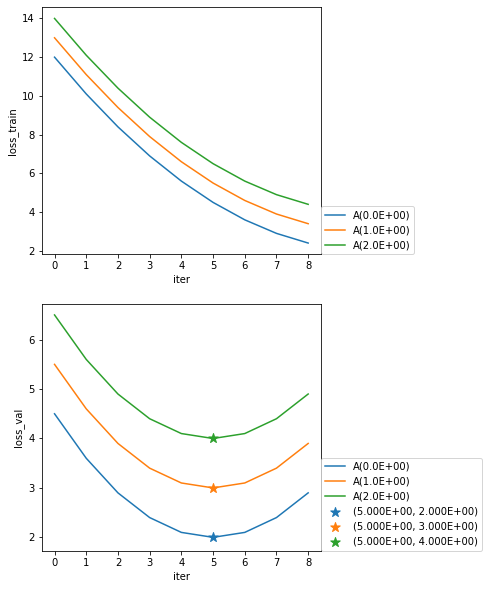

In [2]:
import learnlog
import numpy as np
import threading
import time
%matplotlib inline

def simulate_learning_process(i):

    alpha = 1. * i
    filename = "run_job%d"%i
    
    for iter in range(10):
        iters = np.arange(iter)
        
        #  ********************
        # loging
        learnlog.write_file(
            filename, { "iter": iters,
                "loss_train":2 + 0.1*(iters-10)**2 + 1*alpha,
                "loss_val": 2 + 0.1*(iters-5)**2 + 1*alpha,
                "alpha": alpha,
                "__finish": iter == 9})   # mark for abording from continue_ploting_files
        # ********************
        time.sleep(1 + alpha*0.5)

        
threads = [threading.Thread(target=simulate_learning_process, args=(i,)) for i in range(3)]
for thread in threads: thread.start()

# ********************
# ploting
def get_label(log):
    return "A(%.1E)"%(log["alpha"])
learnlog.continue_ploting_files(["run_job0", "run_job1", "run_job2"],
                    xlabel=["iter", "iter"],
                    ylabel=["loss_train", "loss_val"],
                    mark=[None, "min"],
                    label=get_label,             # broadcasting
                    legend_kargs={"loc":(1,0)})  # broadcasting
# ********************

## Plot

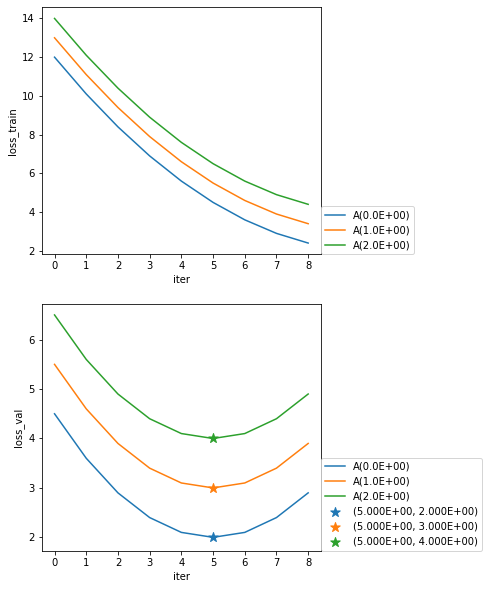

In [4]:
# ********************
# ploting
def get_label(log):
    return "A(%.1E)"%(log["alpha"])
learnlog.plot_files(["run_job0", "run_job1", "run_job2"],
                    xlabel=["iter", "iter"],
                    ylabel=["loss_train", "loss_val"],
                    mark=[None, "min"],
                    label=get_label,
                    legend_kargs={"loc":(1,0)})
# ********************